In [1]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12518554641347875596
]
Device mapping:



In [4]:
train = pd.read_csv('Kaggle/emnist-balanced-train.csv')
test = pd.read_csv('Kaggle/emnist-balanced-test.csv')
mapping = pd.read_csv("Kaggle/emnist-balanced-mapping.txt", 
                      delimiter = ' ', 
                      index_col=0, 
                      header=None, 
                      squeeze=True)

In [5]:
train.shape, test.shape, mapping.shape

((112799, 785), (18799, 785), (47,))

In [6]:
WIDTH = 28
HEIGHT = 28

In [7]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

del train
del test

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112799, 784), (112799,), (18799, 784), (18799,))

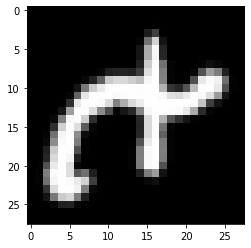

In [11]:
sample = X_train.loc[28]
plt.imshow(sample.values.reshape(28, 28), cmap=plt.cm.gray)
# sample.values, sample.shape

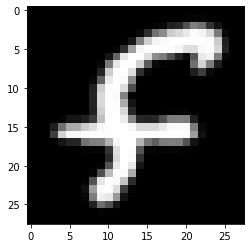

In [12]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

plt.imshow(rotate(sample.values), cmap=plt.cm.gray)

In [13]:
X_train = np.apply_along_axis(rotate, 1, X_train.values)
X_test = np.apply_along_axis(rotate, 1, X_test.values)

In [14]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

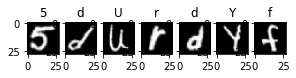

In [16]:
for i in range(101, 108):
    plt.subplot(390 + (i+1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(chr(mapping[y_train[i]]))
#     print(X_train[i])

In [17]:
number_of_classes = y_train.nunique()

# One Hot Encoding
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train.shape, y_test.shape

((112799, 47), (18799, 47))

In [18]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [19]:
# partition to train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size= 0.10, 
                                                  random_state=88)

In [20]:
# model = Sequential()

# model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
# model.add(layers.AveragePooling2D())

# model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(layers.AveragePooling2D())

# model.add(layers.Flatten())

# model.add(layers.Dense(units=120, activation='relu'))

# model.add(layers.Dense(units=84, activation='relu'))

# model.add(layers.Dense(units=47, activation = 'softmax'))

# LeNet-5 Best Submision
# model = Sequential()
# model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(84, activation='relu'))
# model.add(layers.Dense(47, activation='softmax'))

# MNIST top5% 99% acc, rmsprop optimizer
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(47, activation = "softmax"))

# AlexNet

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

In [22]:
optimizer_name = 'sgd'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

model_name = optimizer_name

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_name+'.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    verbose=2, 
                    validation_data=(X_val, y_val),
                   callbacks=[early_stopping, mcp_save, TQDMNotebookCallback()])

Train on 101519 samples, validate on 11280 samples


Epoch 1/30


 - 3383s - loss: 0.8129 - accuracy: 0.7513 - val_loss: 0.3985 - val_accuracy: 0.8574

Epoch 00001: val_loss improved from inf to 0.39854, saving model to sgd.h5
Epoch 2/30


 - 3401s - loss: 0.4689 - accuracy: 0.8398 - val_loss: 0.3498 - val_accuracy: 0.8709

Epoch 00002: val_loss improved from 0.39854 to 0.34980, saving model to sgd.h5
Epoch 3/30


 - 4087s - loss: 0.4136 - accuracy: 0.8555 - val_loss: 0.3300 - val_accuracy: 0.8809

Epoch 00003: val_loss improved from 0.34980 to 0.33005, saving model to sgd.h5
Epoch 4/30


 - 3890s - loss: 0.3829 - accuracy: 0.8648 - val_loss: 0.3170 - val_accuracy: 0.8825

Epoch 00004: val_loss improved from 0.33005 to 0.31697, saving model to sgd.h5
Epoch 5/30


 - 4530s - loss: 0.3604 - accuracy: 0.8715 - val_loss: 0.3100 - val_accuracy: 0.8848

Epoch 00005: val_loss improved from 0.31697 to 0.30996, saving model to sgd.h5
Epoch 6/30


 - 5028s - loss: 0.3457 - accuracy: 0.8755 - val_loss: 0.3040 - val_accuracy: 0.8870

Epoch 00006: val_loss improved from 0.30996 to 0.30396, saving model to sgd.h5
Epoch 7/30


In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [27]:
history.history

NameError: name 'history' is not defined

In [28]:
#%%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

NameError: name 'history' is not defined

In [29]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

NameError: name 'epochs' is not defined

In [30]:
# loss curve
plotgraph(epochs, loss, val_loss)

NameError: name 'epochs' is not defined

In [31]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [32]:
y_pred.shape

(18799, 47)

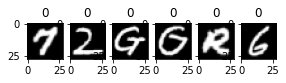

In [33]:
for i in range(10, 16):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(chr(mapping[y_pred[i].argmax()]))

In [34]:
model.save('character_recognizer.h5')

In [35]:
model.evaluate(X_test, y_test)

18799/18799 [==============================] - 456s 24ms/step


[3.850124782397079, 0.023352306336164474]